In [123]:
# load the spam dataset
from google.colab import files
uploaded = files.upload()

Saving SPAM_detection.csv to SPAM_detection (1).csv


In [133]:
from keras.datasets import cifar10
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import tensorflow.keras as tfk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
tfkl = tfk.layers

# Problem One:
Autoencoder

In [96]:
# load the cifar10 dataset
data, info = tfds.load('cifar10', with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [97]:
# process the data into float and normalization
preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])
ae_targets = lambda x, y: (x, x)
ds_train = data['train'].map(preprocess).map(ae_targets).cache().batch(32).repeat().prefetch(5)
ds_test = data["test"].map(preprocess)

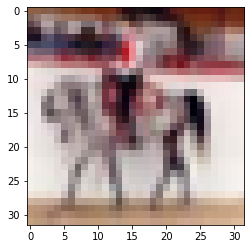

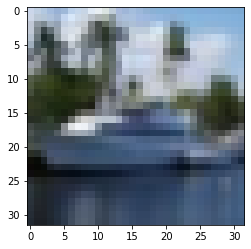

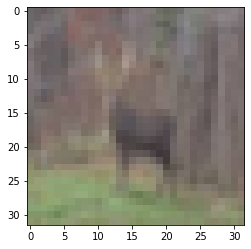

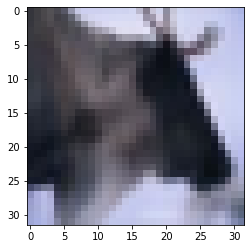

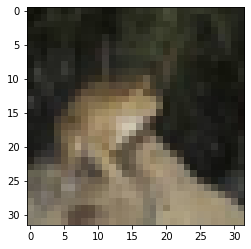

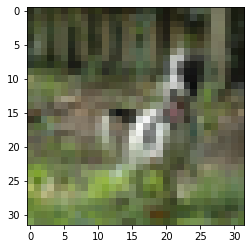

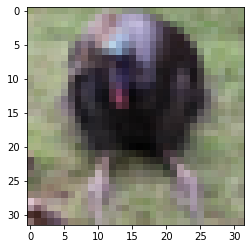

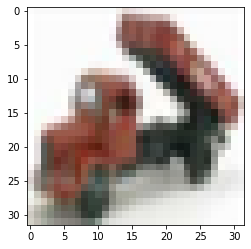

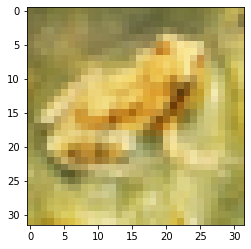

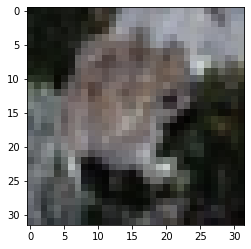

In [51]:
# take a glance
imgs = next(iter(ds_train))[0]
for i in range(10):
  plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
  plt.show()

In [44]:
shape_ = info.features['image'].shape
print(info.features['image'].shape)
print(np.prod(shape_))

(32, 32, 3)
3072


In [99]:
encoder = tfk.Sequential([
  # input shape is the shape of dataset with relu activation function
  tfkl.Conv2D(filters = 32,kernel_size=(4,4), activation=tf.nn.relu,padding="same",input_shape=(32,32,3)),
  # reduce image dimension
  tfkl.MaxPooling2D((2,2),padding="same"),
  tfkl.Conv2D(filters = 32, kernel_size=(3,3),activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D((2,2),padding="same"),
  tfkl.Conv2D(filters = 16,kernel_size=(3,3),activation=tf.nn.relu,padding='same'),
  tfkl.BatchNormalization(),
  # use sigmoid activation for the last layer
  tfkl.Conv2D(4,kernel_size=(1,1),padding='same',activation=tf.nn.sigmoid)
])
encoder.summary()



Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 32, 32, 32)        1568      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 8, 8, 16)          4624      
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 8, 8, 4)         

In [100]:
decoder = tfk.Sequential([
  # shape of autoencoder is (8,8,4)
  tfkl.InputLayer((8,8,4)),
  # use ReLU activation function
  tfkl.Conv2D(16,(3,3), activation=tf.nn.relu,padding="same"),
  # Expand the dimension
  tfkl.UpSampling2D((2,2)),
  tfkl.Conv2D(32,(4,4), activation=tf.nn.relu,padding="same"),
  # Expand the dimension
  tfkl.UpSampling2D((2,2)),
  tfkl.Conv2D(3,(3,3), activation=tf.nn.sigmoid,padding="same"),
])
decoder.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 8, 8, 16)          592       
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 16, 16, 32)        8224      
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 32, 32, 3)         867       
Total params: 9,683
Trainable params: 9,683
Non-trainable params: 0
_________________________________________________________________


In [102]:
# defining placeholder tensors that represent model inputs
x = tfkl.Input(shape_)

# specify the computation to get a prediction
h = encoder(x)
xhat = decoder(h)

# specifying the inputs and outputs
autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

# training happens as usual
autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics = tfk.metrics.Accuracy()
)

# fit on the train set
results = autoencoder.fit(ds_train, steps_per_epoch=50, epochs=10)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_29 (Sequential)   (None, 8, 8, 4)           15572     
_________________________________________________________________
sequential_30 (Sequential)   (None, 32, 32, 3)         9683      
Total params: 25,255
Trainable params: 25,223
Non-trainable params: 32
_________________________________________________________________
Epoch 1/10
50/50 [==============================] - 6s 126ms/step - loss: 0.5974 - accuracy: 4.0690e-07
Epoch 2/10
50/50 [==============================] - 6s 125ms/step - loss: 0.5916 - accuracy: 6.1035e-07
Epoch 3/10
50/50 [==============================] - 6s 126ms/step - loss: 0.5910 - accuracy: 0.0000e+00
Epoch 4/10
50/50 [==============================] - 6s 127ms/step -

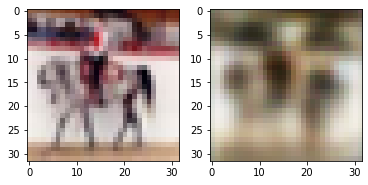

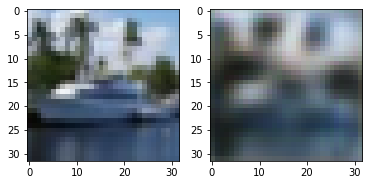

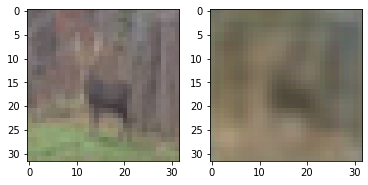

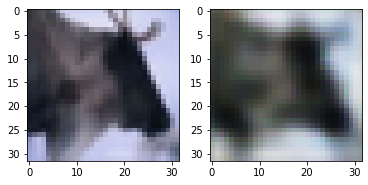

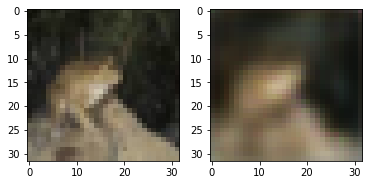

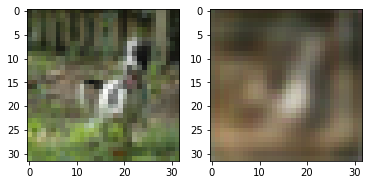

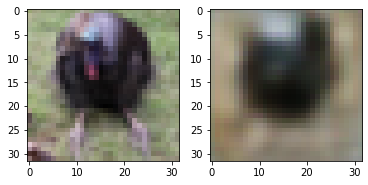

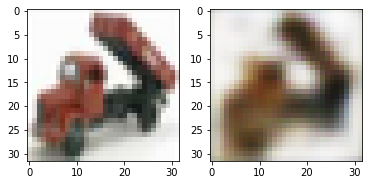

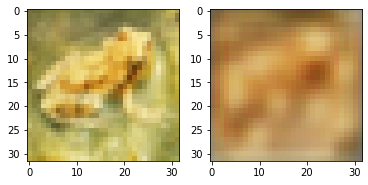

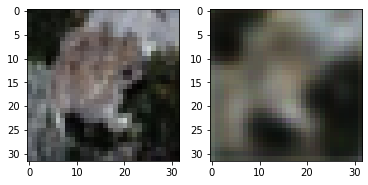

In [63]:
h = encoder(x)
xhat = decoder(h)

# choose some data to show and make comparison
imgs = next(iter(ds_train))[0]
for i in range(10):
  plt.subplot(1, 2, 1)
  plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
  plt.subplot(1, 2, 2, )
  plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
  plt.show()

Text(0.5, 1.0, 'Loss Plot')

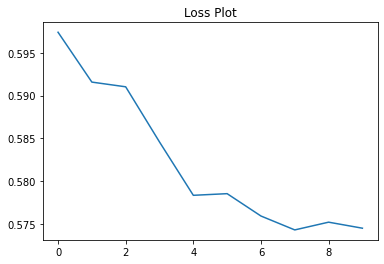

In [103]:
# the loss plot
plt.plot(results.history['loss'])
plt.title('Loss Plot')

# Problem Two
**2.1 Deep CNN**

In [106]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))
# make the dataset normalize
ds_train = data["train"].map(preprocess).cache().batch(32)
ds_test = data["test"].map(preprocess).cache().batch(32)

deep_cnn = tfk.Sequential([
  # try 128 neuron hidden layers and relu activation function
  # padding as the same shape
  tfkl.Conv2D(filters = 128,kernel_size=(3,3),strides=1, activation=tf.nn.relu,padding="same",input_shape=(32,32,3)),
  # decrease the dimension
  tfkl.MaxPooling2D(pool_size=3,padding="same"),
  # like the way explained above
  tfkl.Conv2D(64,kernel_size=(2,2), activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D(pool_size=2,padding="same"),
  tfkl.Conv2D(32,kernel_size=(2,2), activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D(pool_size=2,padding="same"),
  # to avoid overfitting, use drop out layer
  tfkl.Dropout(0.3),
  # condense the dimension
  tfkl.Dense(64,activation="sigmoid"),
  # flatten the vectors
  tfkl.Flatten(),
  tfkl.Dense(10,activation="softmax")
])

deep_cnn.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 11, 11, 64)        32832     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 6, 6, 32)          8224      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 3, 32)        

In [92]:
deep_cnn.compile(
    optimizer = tfk.optimizers.RMSprop(),
    loss = tfk.losses.CategoricalCrossentropy()
)

In [93]:
results = deep_cnn.fit(ds_train,
                       steps_per_epoch=50, 
                       epochs=10, 
                       batch_size = 10,
                       validation_data = ds_test)

Epoch 1/10
50/50 [==============================] - 11s 230ms/step - loss: 2.3550 - val_loss: 2.3253
Epoch 2/10
50/50 [==============================] - 10s 191ms/step - loss: 2.3026 - val_loss: 2.2298
Epoch 3/10
50/50 [==============================] - 9s 189ms/step - loss: 2.2063 - val_loss: 2.1038
Epoch 4/10
50/50 [==============================] - 9s 187ms/step - loss: 2.1200 - val_loss: 2.0461
Epoch 5/10
50/50 [==============================] - 10s 190ms/step - loss: 2.0961 - val_loss: 2.0329
Epoch 6/10
50/50 [==============================] - 9s 184ms/step - loss: 2.0609 - val_loss: 1.9618
Epoch 7/10
50/50 [==============================] - 9s 188ms/step - loss: 2.0427 - val_loss: 1.9329
Epoch 8/10
50/50 [==============================] - 9s 184ms/step - loss: 1.9659 - val_loss: 1.9174
Epoch 9/10
50/50 [==============================] - 9s 184ms/step - loss: 1.9230 - val_loss: 1.8129
Epoch 10/10
50/50 [==============================] - 9s 185ms/step - loss: 1.8940 - val_loss: 1.8

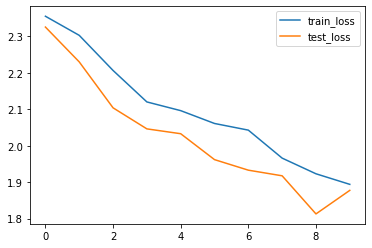

In [94]:
# plot the train loss and validation set loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['train_loss','test_loss'])

**2.2 Transfer Learning**

In [108]:
# use VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

transfer_model = tfk.Sequential([
  # add the convolution base model
  conv_base,
  # decrease the dimension
  tfkl.GlobalMaxPool2D(),
  # condense the dimension
  tfkl.Dense(64,activation='relu'),
  # avoid overfitting
  tfkl.Dropout(0.3),
  tfkl.Dense(10,activation='softmax')                                
])

transfer_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                650       
Total params: 14,748,170
Trainable params: 14,748,170
Non-trainable params: 0
_________________________________________________________________


In [113]:
transfer_model.compile(optimizer = tfk.optimizers.RMSprop(),
                       loss = tfk.losses.CategoricalCrossentropy())

# do not change the base convolutional model
conv_base.trainable = False

results = transfer_model.fit(ds_train, 
                             steps_per_epoch = 20,
                             epochs=5, 
                             batch_size = 10,
                             validation_data = ds_test)

Epoch 1/5
20/20 [==============================] - 110s 6s/step - loss: 1.8826 - val_loss: 1.7999
Epoch 2/5
20/20 [==============================] - 111s 6s/step - loss: 1.7874 - val_loss: 1.7570
Epoch 3/5
20/20 [==============================] - 110s 6s/step - loss: 1.8013 - val_loss: 1.7162
Epoch 4/5
20/20 [==============================] - 111s 6s/step - loss: 1.7764 - val_loss: 1.7038
Epoch 5/5
20/20 [==============================] - 111s 6s/step - loss: 1.7851 - val_loss: 1.6671


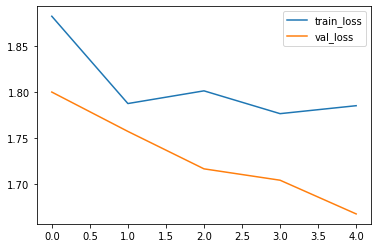

In [115]:
# plot train loss and validation set loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['train_loss','val_loss'])

# Problem Three
**Text Classification**

In [130]:
# load the spam dataset
spam_df = pd.read_csv('SPAM_detection (1).csv')
spam_df.sample(5)

,Message,category_val
2813,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",0
1739,K go and sleep well. Take rest:-).,0
2869,"Aight, tomorrow around &lt;#&gt; it is",0
153,Ok... Ur typical reply...,0
3191,Hi neva worry bout da truth coz the truth will...,0


In [131]:
# let all word in lower format
spam_df['Message'] = spam_df['Message'].str.lower()

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: Message, Length: 5572, dtype: object

In [161]:
text_part = spam_df['Message'].values
val = spam_df['category_val'].values

In [162]:
# transform word to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_part)
text_part = tokenizer.texts_to_sequences(text_part)
text_part = sequence.pad_sequences(text_part)

In [163]:
print(text_part.shape)
print(val.shape)

(5572, 189)
(5572,)


In [168]:
random_state = 42
# split dataset randomly
X_train, X_test, y_train, y_test = train_test_split(text_part,
                                                val,
                                                test_size=0.3,
                                                random_state=random_state)

In [169]:
print(X_train.shape)
print(X_test.shape)

(3900, 189)
(1672, 189)


**RNN**

In [185]:
text_model_rnn = tfk.Sequential([
  # to do encode work
  tfkl.Embedding(len(tokenizer.word_index)+1,10,input_length=X_train.shape[1]),
  # add LSTM layer
  tfkl.LSTM(64,return_sequences=True),
  # decrease the dimension
  tfkl.GlobalMaxPool1D(),
  # avoid overfitting
  tfkl.Dropout(0.3),
  tfkl.Dense(1,activation='sigmoid')                                
])

# this is binary classification problem
# use binary_crossentropy as loss function
text_model_rnn.compile(optimizer = tfk.optimizers.RMSprop(),
                   loss = 'binary_crossentropy')

text_model_rnn.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 189, 10)           90050     
_________________________________________________________________
lstm_7 (LSTM)                (None, 189, 64)           19200     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 109,315
Trainable params: 109,315
Non-trainable params: 0
_________________________________________________________________


In [186]:
text_model_rnn.fit(X_train,y_train,
                   epochs=10,batch_size=32,
                   validation_data=(X_test,y_test))

Epoch 1/10
122/122 [==============================] - 14s 113ms/step - loss: 0.4082 - val_loss: 0.3895
Epoch 2/10
122/122 [==============================] - 13s 109ms/step - loss: 0.3648 - val_loss: 0.2651
Epoch 3/10
122/122 [==============================] - 13s 109ms/step - loss: 0.2961 - val_loss: 0.3416
Epoch 4/10
122/122 [==============================] - 13s 109ms/step - loss: 0.1905 - val_loss: 0.1143
Epoch 5/10
122/122 [==============================] - 13s 110ms/step - loss: 0.0817 - val_loss: 0.0721
Epoch 6/10
122/122 [==============================] - 13s 109ms/step - loss: 0.0621 - val_loss: 0.0635
Epoch 7/10
122/122 [==============================] - 14s 112ms/step - loss: 0.0458 - val_loss: 0.0620
Epoch 8/10
122/122 [==============================] - 13s 110ms/step - loss: 0.0385 - val_loss: 0.0481
Epoch 9/10
122/122 [==============================] - 14s 111ms/step - loss: 0.0325 - val_loss: 0.0543
Epoch 10/10
122/122 [==============================] - 14s 111ms/step - l

In [187]:
# do the prediction
rnn_prediction = text_model_rnn.predict(X_test)

**CNN**

In [237]:
text_model_cnn = tfk.Sequential([
  # 64 neuron hidden layers and activation function as relu
  tfkl.Conv1D(filters= 64,kernel_size=2,strides=1,activation='relu',padding='same',input_shape=(X_train.shape[1],1)),
  # use max pooling to decrease dimension
  tfkl.MaxPooling1D(pool_size=2,padding='same'),
  tfkl.Conv1D(filters = 64, kernel_size=2,strides=1,activation='relu',padding='same'),
  # use drop out layer to avoid overfitting
  tfkl.Dropout(0.3),
  tfkl.Conv1D(32,kernel_size=2,strides=1,activation='relu',padding='same'),
  # Flatten the vector to 3040    
  tfkl.Flatten(),
  # condense the dimension to 16 and 1
  tfkl.Dense(16,activation='relu'),
  tfkl.Dense(1,activation='sigmoid')                     
])
text_model_cnn.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 189, 64)           192       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 95, 64)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 95, 64)            8256      
_________________________________________________________________
dropout_22 (Dropout)         (None, 95, 64)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 95, 32)            4128      
_________________________________________________________________
flatten_19 (Flatten)         (None, 3040)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 16)              

In [229]:
# change the shape of X data set
X_train_ = X_train[:,:,None]
X_test = X_test[:,:,None]

In [238]:
text_model_cnn.compile(optimizer = tfk.optimizers.Adam(),
                       loss = 'binary_crossentropy')

In [239]:
text_model_cnn.fit(X_train_,y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data=(X_test_,y_test))

Epoch 1/10
122/122 [==============================] - 2s 20ms/step - loss: 1.6366 - val_loss: 0.3167
Epoch 2/10
122/122 [==============================] - 2s 19ms/step - loss: 0.3501 - val_loss: 0.3425
Epoch 3/10
122/122 [==============================] - 2s 19ms/step - loss: 0.3456 - val_loss: 0.3108
Epoch 4/10
122/122 [==============================] - 2s 19ms/step - loss: 0.3429 - val_loss: 0.2915
Epoch 5/10
122/122 [==============================] - 2s 19ms/step - loss: 0.2986 - val_loss: 0.2789
Epoch 6/10
122/122 [==============================] - 2s 20ms/step - loss: 0.2845 - val_loss: 0.2989
Epoch 7/10
122/122 [==============================] - 2s 20ms/step - loss: 0.2785 - val_loss: 0.3081
Epoch 8/10
122/122 [==============================] - 2s 20ms/step - loss: 0.2814 - val_loss: 0.2808
Epoch 9/10
122/122 [==============================] - 2s 20ms/step - loss: 0.2717 - val_loss: 0.2770
Epoch 10/10
122/122 [==============================] - 2s 19ms/step - loss: 0.2655 - val_lo

In [240]:
# make cnn prediction
cnn_prediction = text_model_cnn.predict(X_test_)

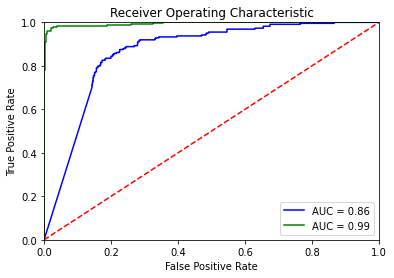

In [249]:
# plot the ROC curve with AUC
plt.title('ROC curve for RNN and CNN')
plt.plot(cnn_fpr, cnn_tpr, 'b', label = 'AUC = %0.2f' % cnn_roc_auc)
plt.plot(rnn_fpr,rnn_tpr,'g',label='AUC = %0.2f' % rnn_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()